# Project - Formandos terminados

## 1 - Imports

In [2]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile

import seaborn as sn
from matplotlib import pyplot as plt

## 2 - Read File

In [3]:
form = pd.read_excel("databases/Formandos_Terminados2018.xlsx")

In [7]:
form.shape

(124056, 63)

In [8]:
form.head(2)

,UTE_ID,CodCEFP,CodMedidaOrcam,Descritivo CodMedidaOrcam,Sexo,DataNascimento,IdadeEmAnos,Categoria,CodHabilitacao,Habilitacao,...,Mes9_Tipo,Mes10,Mes10_Remuneracao,Mes10_Tipo,Mes11,Mes11_Remuneracao,Mes11_Tipo,Mes12,Mes12_Remuneracao,Mes12_Tipo
0,7206,308,D111206,Cursos de Especialização Tecnológica,M,1964-01-18,55,2,12,12 Anos,...,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
1,17170,206,D111206,Cursos de Especialização Tecnológica,F,1976-03-24,42,2,12,12 Anos,...,NaN,1,360.0,TCO,0,NaN,NaN,0,NaN,NaN


## 3 - Check nulls and variable values

In [9]:
form.isnull().sum()

UTE_ID                           0
CodCEFP                          0
CodMedidaOrcam                   0
Descritivo CodMedidaOrcam        0
Sexo                             0
                             ...  
Mes11_Remuneracao            85805
Mes11_Tipo                   85812
Mes12                            0
Mes12_Remuneracao            88193
Mes12_Tipo                   88200
Length: 63, dtype: int64

In [29]:
# Número de valores únicos da variável AreaFormacao
form["AreaFormacao"].nunique()

45

In [11]:
# Valores únicos da variável MotivoSaída
form['MotivoSaída'].unique()

array(['Desistente', 'Aprovado', 'Reprovado', 'Sem Classificação'],
      dtype=object)

As observações de interesse para o nosso trabalho são as que têm MotivoSaída = Aprovado.

## 4 - Feature engeneering

In [13]:
# Criar DataFrame apenas com formandos aprovados
aprovados = form[form['MotivoSaída'] == 'Aprovado']

#### 4.1 - Criação da variável SomaMesesRemunerados

Apos selecionar os formandos com estado de conclusao «aprovado» vamos criar uma variável que permite quantificar o número de meses remunerados após o final da formação ("SomaMesesRemunerados"). 
Deste modo, é possivel criar uma variavel target com os casos em que existe remuneraçao igual ou superior a 6 meses após conclusão da intervençao (considerados casos positivos pelo IEFP).

In [16]:
aprovados["SomaMesesRemunerados"] = 0
form["SomaMesesRemunerados"] = 0

for i in range(1, 13):
    mes = i
    aprovados["SomaMesesRemunerados"] += aprovados["Mes" + str(mes)]
    form["SomaMesesRemunerados"] += form["Mes" + str(mes)]

<ipython-input-16-e465a9603a8a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aprovados["SomaMesesRemunerados"] = 0
<ipython-input-16-e465a9603a8a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aprovados["SomaMesesRemunerados"] += aprovados["Mes" + str(mes)]


In [17]:
# Frequencias relativas do número de meses remunerados
total = aprovados["SomaMesesRemunerados"].count()
estatistica_aprovados = aprovados["SomaMesesRemunerados"].value_counts() / total * 100

estatistica_aprovados

0     45.166152
12    15.074769
8      6.128649
9      5.805839
10     4.781628
11     3.749110
7      3.677902
6      2.877997
1      2.657251
5      2.634702
4      2.554000
2      2.448374
3      2.443627
Name: SomaMesesRemunerados, dtype: float64

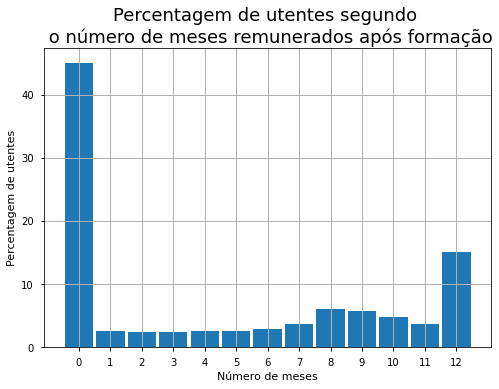

In [24]:
# Gráfico para apresentação de estatísticas
plt.style.use('seaborn-notebook')

labels=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"] 

values = estatistica_aprovados.sort_index()

plt.bar(labels, values, width=0.9)
plt.title("Percentagem de utentes segundo \n o número de meses remunerados após formação", size=18)
plt.xlabel("Número de meses")
plt.ylabel("Percentagem de utentes")
plt.grid(zorder=0)

Podemos observar que cerca de 45% dos utentes não tiveram nenhuma remuneração nos 12 meses seguintes ao termino da formação. É ainda importante referir, que o segundo valor mais frequente é o 12, ou seja, maior parte dos utentes remunerados acaba por ficar empregado durante pelo menos 1 ano. 

#### 4.2 - Criação da variável Sucesso

Criação da variável binária sucesso. Um caso de sucesso corresponde a um utente que nos 12 meses após o término da formação teve pelo menos 6 meses remunerados.

In [26]:
# iniciar nova coluna Sucessos, com todos os valores a zero
form["Sucessos"] = 0

# Para as observações com mais de 6 meses de remuneração atribuir 1 à variável sucesso 
form["Sucessos"][(form["SomaMesesRemunerados"] >= 6)] = 1
# !!!nota estamos a fazer a estatistica com valores de UTE_ID duplicados em alguns casos devido a prazos distintos

<ipython-input-26-f3cc9652be59>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  form["Sucessos"][(form["SomaMesesRemunerados"] >= 6)] = 1


Text(0, 0.5, 'Número de utentes')

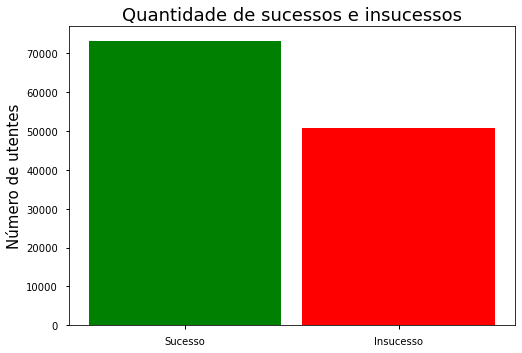

In [47]:
# Gráfico relativo ao sucesso e insucesso

outcome = ["Sucesso", "Insucesso"]

values_succ = form["Sucessos"].value_counts()

plt.bar(outcome, values_succ, width=0.9, color=["green", "red"])
plt.title("Quantidade de sucessos e insucessos", size=18)
plt.ylabel("Número de utentes", size=15)

#### 4.3 - Valores duplicados na variável UTE_ID

In [42]:
total = aprovados['UTE_ID'].count()

In [43]:
unicos = aprovados['UTE_ID'].nunique()
unicos

72343

In [48]:
# calcular o número de UTE_ID's repetidos
duplicados = total - unicos
print("Existem " + str(duplicados) + " UTE_ID's repetidos")

Existem 11917 UTE_ID's repetidos


In [41]:
# Verificar duas observações com o mesmo UTE_ID
form[form['UTE_ID'] == 4485606]

,UTE_ID,CodCEFP,CodMedidaOrcam,Descritivo CodMedidaOrcam,Sexo,DataNascimento,IdadeEmAnos,Categoria,CodHabilitacao,Habilitacao,...,Mes10_Remuneracao,Mes10_Tipo,Mes11,Mes11_Remuneracao,Mes11_Tipo,Mes12,Mes12_Remuneracao,Mes12_Tipo,SomaMesesRemunerados,Sucessos
571,4485606,134,D111201,Cursos de Aprendizagem - Gestão Direta,M,1994-04-30,24,2,09,9 Anos,...,NaN,NaN,0,NaN,NaN,0,NaN,NaN,3,0
572,4485606,134,D111202,Cursos de Aprendizagem - Entidades Externas,M,1994-04-30,24,2,09,9 Anos,...,NaN,NaN,0,NaN,NaN,0,NaN,NaN,1,0


In [40]:
# ??
form.DataFim[form.UTE_ID==4485606]

571   2018-11-09
572   2018-03-20
Name: DataFim, dtype: datetime64[ns]

In [52]:
# !!! tentativa de remoção de duplicados no entanto ha que ter em conta que a remoçao nao pode ser cega

teste = aprovados.drop_duplicates(subset=['UTE_ID'])
teste.shape

(72343, 64)

In [53]:
#!!! avaliar alguns dos duplicados

duplicados = form.duplicated(subset=['UTE_ID'])
teste_duplicados = form[duplicados]
teste_duplicados.head(5)

,UTE_ID,CodCEFP,CodMedidaOrcam,Descritivo CodMedidaOrcam,Sexo,DataNascimento,IdadeEmAnos,Categoria,CodHabilitacao,Habilitacao,...,Mes10_Remuneracao,Mes10_Tipo,Mes11,Mes11_Remuneracao,Mes11_Tipo,Mes12,Mes12_Remuneracao,Mes12_Tipo,SomaMesesRemunerados,Sucessos
141,1864123,315,D111206,Cursos de Especialização Tecnológica,M,1964-04-05,54,2,PS,Pós-Secundário,...,729.0,TCO,0,NaN,NaN,0,NaN,NaN,2,0
326,3432294,313,D111206,Cursos de Especialização Tecnológica,M,1986-04-02,32,2,12,12 Anos,...,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,0
412,4065237,401,D111202,Cursos de Aprendizagem - Entidades Externas,F,1990-01-02,29,2,09,9 Anos,...,166.0,TCO,0,NaN,NaN,0,NaN,NaN,10,1
518,4379984,206,D111202,Cursos de Aprendizagem - Entidades Externas,F,1993-10-26,25,1,09,9 Anos,...,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,0
572,4485606,134,D111202,Cursos de Aprendizagem - Entidades Externas,M,1994-04-30,24,2,09,9 Anos,...,NaN,NaN,0,NaN,NaN,0,NaN,NaN,1,0
